In [1]:
from datetime import datetime
import automlShortForecast.util as util
import pandas as pd
from automlShortForecast.automlShortForecast import automlShortForecast
from sklearn import linear_model
from matplotlib import pyplot as plt
import pickle

In [2]:
master_id = '../new/CGNWF0046' #文件夹
longitude = f'{112.647:.3f}'
latitude = f'{21.938:.3f}'
start_date = datetime.strptime('2018-07-01', '%Y-%m-%d')
end_date = datetime.strptime('2019-12-31', '%Y-%m-%d')
ts = pd.date_range(start_date, end_date, freq='D')
horizon = 48

In [3]:
pc = (f'{master_id}/speed_to_power.csv')

In [4]:
obs_data = {}
#生成power和speed的dataframe
for attr in ('speed', 'power'):
    count = 0
    for t in ts:
        if count==0:
            data=pd.read_csv(f'{master_id}/{attr}s/{t:%Y-%m-%d}.csv')
            count+=1
        else:
            data=pd.concat((data,pd.read_csv(f'{master_id}/{attr}s/{t:%Y-%m-%d}.csv')))
    obs_data[attr] = pd.Series(data.iloc[:, -1].values, index=data['utcTimeStamp'])
# print(obs_data)

In [5]:
nwp_data = {}
#生成EC和GFS的dataframe
for nwp in ('EC', 'GFS'):
    count = 0
    for t in ts - pd.Timedelta(hours=12):
        if count==0:
            data=pd.read_csv(f'../new/{longitude}/{latitude}/{nwp}/{t:%Y-%m-%d_%H%M%S}.csv')
            count+=1
        else:
            data=pd.concat((data,pd.read_csv(f'../new/{longitude}/{latitude}/{nwp}/{t:%Y-%m-%d_%H%M%S}.csv')))

    data['RHO'] = data['PRES'] * 1e2 / (287.05 * (data['TMP'] + 273.15))
    nwp_data[nwp] = data

In [6]:
x_df, y_df = automlShortForecast.create_basic_feature(obs_data, nwp_data, ts, horizon)


In [7]:
def feature_clean(x_df, y_df=None, cleaning_x=True):
    if cleaning_x:
        if isinstance(x_df, pd.DataFrame):
            is_valid = x_df.notnull().all(axis=1)
            print(89, is_valid.shape)

        else:
            is_valid = x_df.notnull()
#             print(92, is_valid.shape)
    else:
        is_valid = pd.Series(np.ones(len(x_df), dtype=bool), index=x_df.index)
    if y_df is not None:
        if isinstance(y_df, pd.DataFrame):
            is_valid = is_valid & y_df.notnull().all(axis=1)
        else:
            is_valid = is_valid & y_df.notnull()
    x_clean = x_df.loc[is_valid]
#     print(99, x_clean.shape)
#     print(100, is_valid)
#     print(101, )
    if y_df is not None:
        y_clean = y_df.loc[is_valid]
        return x_clean, y_clean, is_valid
    else:
        return x_clean, is_valid

In [8]:
def data_prepare(x_df):
    x_df = util.polar_to_cart(x_df)
    x_df = util.add_feature_wdcut(x_df, n_sector=8, one_hot_encoding=True)
    x_df = util.add_feature_rho_crossed(x_df, '.ws')
    return x_df

In [9]:
def _1st_stacking_feature(nwp):
    input_feature = [nwp + '.ws_rho1', nwp + '.ws_rho2', nwp + '.ws_angles', nwp + '.ws',
                     nwp + '.wd', nwp + '.rho', nwp + '.dist', nwp + '.u', nwp + '.v']
    input_feature.extend(['{}.wd_cut_s{}'.format(nwp, n) for n in range(8)])
    output_feature = nwp + '.pre_ws'
    return input_feature, output_feature

In [10]:
def LinearModel():
    return linear_model.LinearRegression()

# PreprocessingLinearModel:
    original data preprocessing and training
    input:
        x_df:feature frame
        y_df:label frame
        pickle_name:model weight name
     return: 
        trained model 

In [11]:
def PreprocessingLinearModel(x_df, y_df,pickle_name='Linear_model.pkl'):
    x_df, y_df, _ = feature_clean(x_df, y_df, cleaning_x=True)
    x_df = data_prepare(x_df)
    input_feature1, output_feature1 = _1st_stacking_feature('EC')
    input_feature2, output_feature2 = _1st_stacking_feature('GFS')
    input_feature=input_feature1+input_feature2
    model=LinearModel()
    fitted_model=model.fit(x_df[input_feature], y_df)
    y_pred=fitted_model.predict(x_df[input_feature])
    with open(pickle_name, 'wb') as file:
        pickle.dump(fitted_model, file)
    plt.figure(figsize=(20,10))
    plt.plot(y_pred)
    plt.plot(y_df)
    plt.show()
    return fitted_model
    
    

# PreprocessingLinearModel:
    original data preprocessing and testing
    input:
        x_df:feature frame
        pickle_name:model weight name
     return: 
        predicted value

In [14]:
def TestLinearModel(x_df,pickle_name='Linear_model.pkl'):
    x_df,_ = feature_clean(x_df, None, cleaning_x=True)
    x_df = data_prepare(x_df)
    input_feature1, output_feature1 = _1st_stacking_feature('EC')
    input_feature2, output_feature2 = _1st_stacking_feature('GFS')
    input_feature=input_feature1+input_feature2
    model=pickle.load(open(pickle_name, 'rb'))
    y_pred=model.predict(x_df[input_feature])
    plt.figure(figsize=(20,10))
    plt.plot(y_pred)
    plt.show()
    return y_pred

89 (26901,)
n_sector 8


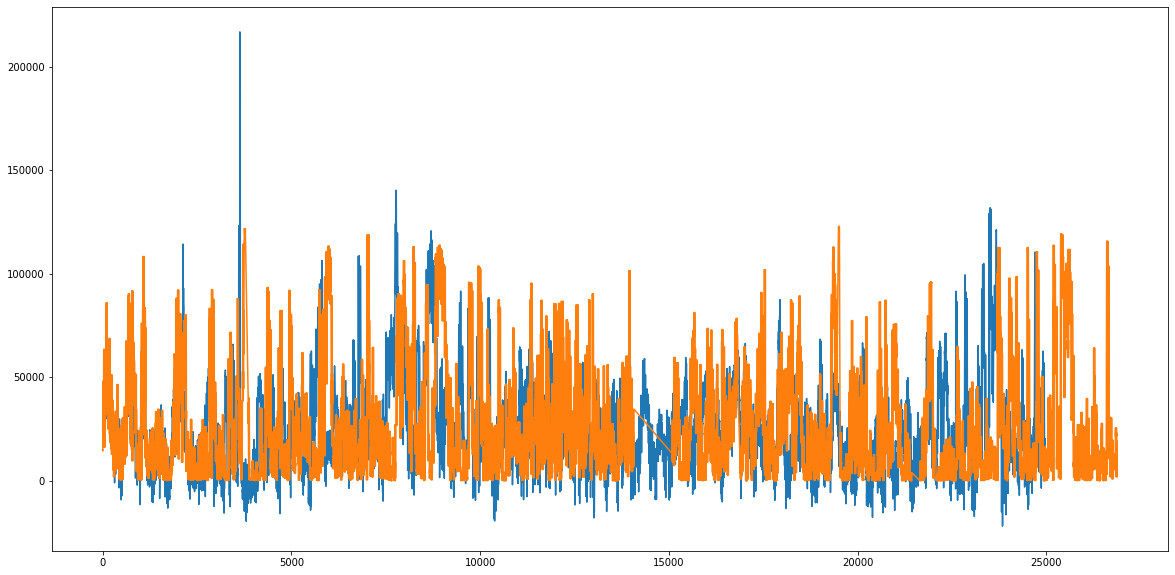

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
PreprocessingLinearModel(x_df,y_df[['power']])

89 (26901,)
n_sector 8


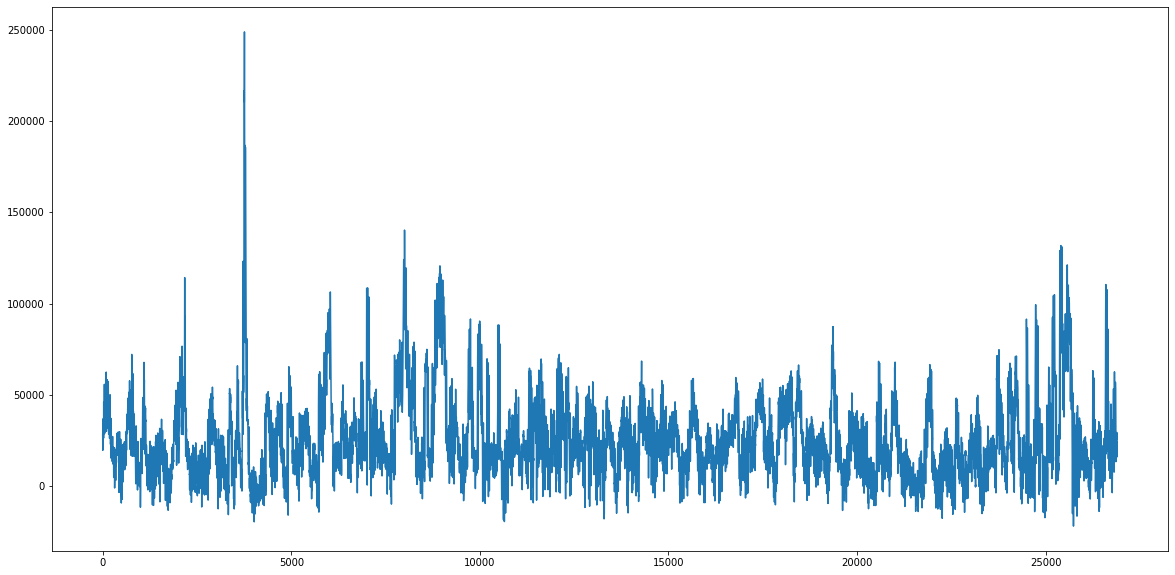

In [16]:
y_ped=TestLinearModel(x_df)